<h1> 1. Introduction


Toronto is one of the most densely populated areas in Canada. Being the land of opportunity, it brings in a variety of people from different ethnic backgrounds to the core city of Canada, Toronto. It is a place where people can try the best of each culture, either while they work or just passing through. Toronto is well known for its great food.

The objective of this project is to use Foursquare location data and regional clustering of venue information to determine what might be the ‘best’ neighbourhood in Toronto to open a restaurant

<h1> 2. Business Problem

A friend of mine, a well established entrepreneur, contacted us a couple of days ago for prospects of opening up a new restaurant in Toronto. 

His company runs a couple of well-established brands across Europe. Originally from Turkey, they are looking for opportunities to expand into Canada and they would like to know where exactly in Toronto would it be best to open up a new restaurant to test the waters.

<h1>3. Data

Using web scraping, the information about the neighborhoods was gathered in a data frame. 

The Geocoder Python package was used to retrieve the latitudes and longitudes of each borough. After some modifications, this information was used as input for the Foursquare API to get the availability and information of venues in the respective neighborhoods.

I will comment on each step along the way of data manipulation and exploration as I show what I do in the following parts of the notebook. 

Stay tuned :)

<h1>4. Methodology and EDA

**Importing the required libraries:**

In [1]:
######to print all the outputs within a cell######
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans
import folium # map rendering library
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.cm as cm
import matplotlib.colors as colors

**Getting and scraping of Toronto Borough & Neighborhood data from Wiki:**

In [2]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.request('GET', URL)
soup = BeautifulSoup(page.content, "html.parser")

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df = pd.DataFrame(data = table_contents)

In [3]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


**Coordinates for the Neighborhoods:**

In [4]:
lat_lng_coords = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv")
neighborhoods = df.join(lat_lng_coords, how='left')
neighborhoods.drop(columns=['Postal Code'], inplace=True)
neighborhoods = neighborhoods[neighborhoods.Borough.str.contains('Toronto')].reset_index(drop=True)

In [5]:
neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.692657,-79.264848
2,M5C,Downtown Toronto,St. James Town,43.799525,-79.318389
3,M4E,East Toronto,The Beaches,43.786947,-79.385975
4,M5E,Downtown Toronto,Berczy Park,43.757490,-79.374714


In [6]:
address = 'Toronto'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

**_The following section creates a map of Toronto (only for Boroughs with "Toronto" in their names) <br> along with the locations of all the neighborhoods marked:_**

In [7]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

In [8]:
map_toronto

**Now let's get the nearby venues that are within 500 meters from neighborhood centers:**

In [9]:
CLIENT_ID = 'LKPF30LKMYSAKW0PKO5AQSQ1QOXOQ3FDJFMR1ZYWBCKRST0A' # your Foursquare ID
CLIENT_SECRET = 'E3DJ5ZKXPUTXURURPZSQ2DQRYFQBIHGGJTYHCPPMHK3P3OI3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [10]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

In [13]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
1,"Regent Park, Harbourfront",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
2,"Regent Park, Harbourfront",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant
3,"Regent Park, Harbourfront",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
4,"Regent Park, Harbourfront",43.763573,-79.188711,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location


_My client is interested in opening a new restaurant. That is, a restaurant where people can enjoy quality time with loved ones over a good meal. Initially, the client wanted to see location and distribution of restaurants with Turkish cuisine or similar._ <br>

_Upon closer inspection, there was no restaurant serving Turkish food and only a handful serving mediterranean or middle eastern cuisine. So we decided to see all of the restaurants in general, leaving out places like fast-food alternatives and diners etc._ <br>

_So this following section groups the venues in terms of whether they are a restaurant or not; creating a new variable calles **"Is_restaurant"**_

In [14]:
toronto_venues['Is_restaurant'] = np.where(toronto_venues['Venue Category'].str.contains('Restaurant'),1,0)

In [15]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Is_restaurant
0,"Regent Park, Harbourfront",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank,0
1,"Regent Park, Harbourfront",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store,0
2,"Regent Park, Harbourfront",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant,1
3,"Regent Park, Harbourfront",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant,1
4,"Regent Park, Harbourfront",43.763573,-79.188711,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location,0


In [16]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']
toronto_onehot['Is_restaurant'] = toronto_venues['Is_restaurant']

toronto_onehot = toronto_onehot.reindex(columns=(
    ['Neighborhood'] + list([a for a in toronto_onehot.columns if a != 'Neighborhood'])))

toronto_onehot.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Knitting Store,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Sporting Goods Shop,Stationery Store,Steakhouse,Supplement Shop,Sushi Restaurant,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Is_restaurant
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

**Getting the frequency of different types of venues, including our newly created variable :is_restaurant :**

In [17]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Knitting Store,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Sporting Goods Shop,Stationery Store,Steakhouse,Supplement Shop,Sushi Restaurant,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Is_restaurant
0,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.055556,0.027778,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027778,0.0,0.055556,0.0,0.0,0.0,0.000000,0.0,0.0,0.055556,0.0,0.0,0.027778,0.000000,0.0,0.027778,0.0,0.083333,0.0,0.0,0.027778,0.000000,0.0,0.0,0.027778,0.0,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027778,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.027778,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.055556,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027778,0.0,0.0,0.0,0.000000,0.027778,0.0,0.0,0.0,0.0,0.0,0.027778,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027778,0.027778,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.027778,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027778,0.222222
1,"CN Tower, King and Spadina, Ra

For the purposes of this assignment, <br> we would like to see how similar the neighborhoods are in terms of their having restaurants or not.

Hence, we will be creating a new dataframe called "toronto_grouped_km" which will be used to train the Kmeans model

In [18]:
toronto_grouped_km = toronto_grouped[['Neighborhood','Is_restaurant']]

<h1>5. K-means clustering

As a general rule, we will draw a visualizer to decide on the best K value possible <br>

To do this, we use the **Elbow method** and find out the best possible K value. <br>

As we can see in the figure below, the best value for K is 5

C:\Users\samete\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:312: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
C:\Users\samete\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=20), k=None)

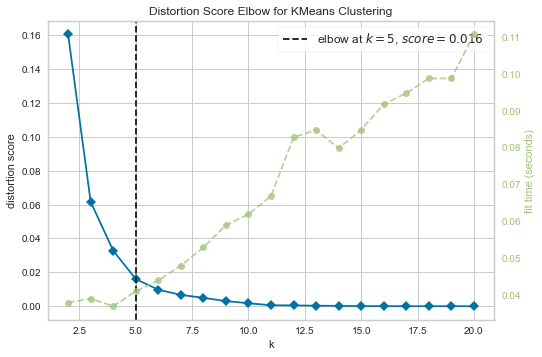

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
X = toronto_grouped_km[['Is_restaurant']]
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

**Training the Kmeans model with K=5, as proposed by the above chart:**

In [22]:
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, init='k-means++', max_iter=50, random_state=8)
kmeans.fit(X)
kmeans.labels_

KMeans(max_iter=50, n_clusters=5, random_state=8)

array([0, 3, 1, 0, 0, 4, 1, 0, 1, 1, 3, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       3, 0, 1, 1, 2, 4, 0, 1, 0, 0, 1, 2, 1, 4, 3, 0])

In [23]:
toronto_grouped['Clusters'] = kmeans.labels_

In [24]:
toronto_grouped

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Knitting Store,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Sporting Goods Shop,Stationery Store,Steakhouse,Supplement Shop,Sushi Restaurant,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Is_restaurant,Clusters
0,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.055556,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.055556,0.027778,0.027778,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.055556,0.00000,0.00,0.000000,0.000000,0.00,0.000000,0.055556,0.000000,0.000000,0.027778,0.000000,0.000000,0.027778,0.000000,0.083333,0.00,0.0,0.027778,0.000000,0.000000,0.0,0.027778,0.000000,0.027778,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.027778,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.027778,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.00,0.027778,0.000000,0.00,0.000000,0.000000,0.

**After inserting the cluster labels back into the toronto_grouped dataframe, <br> 
we need to bring together this dataframe with the neighborhoods dataframe:**

In [25]:
toronto_merged = neighborhoods.join(toronto_grouped.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.drop(axis=0, index=4, inplace = True) #deleting the "M5E" where no nearby venues was returned
toronto_merged.reset_index(inplace = True, drop = True)
toronto_merged['Clusters'] = toronto_merged['Clusters'].astype('int32')

In [26]:
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Knitting Store,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Sporting Goods Shop,Stationery Store,Steakhouse,Supplement Shop,Sushi Restaurant,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Is_restaurant,Clusters
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.111111,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.692657,-79.264848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

**Visualizing the cluseter on top of the neighborhoods points in the Folium map:**

In [27]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    

In [28]:
map_clusters

In [29]:
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Knitting Store,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Sporting Goods Shop,Stationery Store,Steakhouse,Supplement Shop,Sushi Restaurant,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Is_restaurant,Clusters
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.111111,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.692657,-79.264848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

**Visualizing the number of neighborhoods and average number of restaurants per cluster:**

<BarContainer object of 5 artists>

Text(0, 0.5, 'No of Neighborhoods')

Text(0.5, 0, 'Cluster')

Text(0.5, 1.0, 'How many Neighborhoods per Cluster')

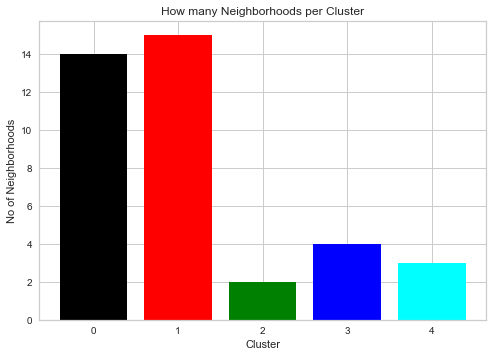

In [30]:
performance = toronto_merged['Clusters'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Clusters'].tolist()
plt.bar(np.arange(kclusters),perf, align='center', alpha=1, color=['black', 'red', 'green', 'blue', 'cyan'])
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [31]:
toronto_merged.groupby(['Clusters']).mean()['Is_restaurant']

Clusters
0    0.242371
1    0.000000
2    0.467391
3    0.123643
4    0.349206
Name: Is_restaurant, dtype: float64

<BarContainer object of 5 artists>

Text(0, 0.5, 'Mean')

Text(0.5, 0, 'Cluster')

Text(0.5, 1.0, 'Average number of Restaurants per Cluster')

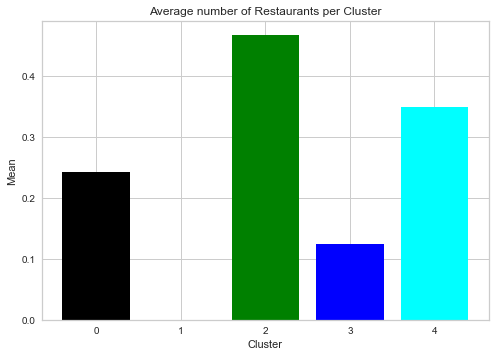

In [32]:
clusters_mean = toronto_merged.groupby(['Clusters']).mean()['Is_restaurant']

perf = clusters_mean
plt.bar(np.arange(kclusters), perf, align='center', alpha=1, color=['black', 'red', 'green', 'blue', 'cyan'])
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Restaurants per Cluster')

plt.show()

<h1>6. Analysis

Some remarks to be made here are:

- First we took the business problem, decided on the methodoloy, and acquired the data accordingly
- We visualized the locations and got the venue data using a combination of scraping techniques and API calls
- We created a new feature to capture more info about restaurants
- We, then, clustered the neighborhoods based on the newly created feature, and visualized the result using Folium.
- The bars above clearly show that Cluster-1, despite being centrally located, does not have many restaurants
- Cluster-2 has the highest average number of restaurants. As a result, the competition is expected to be **very high** in these neighborhoods.
- Cluster-4 has the second highest and Cluster-0 has the third highest average number of restaurants

<h1>7. Conclusion

The project and recommendation could be further improved by integrating more external data, census data, and building a segmentation model using hexagonal geolocation data.

However, our current analysis and findings indicate that **Cluster-1** has the highest potential of success, given how the neighborhoods in this Cluster are centrally located and how little competition there is